# Analyzing the Experimentally Reconstructed Wavefunctions

The wavefunctions produced in the
[QCQMC](https://www.nature.com/articles/s41586-021-04351-z) paper are available
for download  from [zenodo](https://zenodo.org/records/10141262).

In [2]:
import urllib.request
import tarfile

stream = urllib.request.urlopen("https://zenodo.org/records/10141262/files/qcqmc_data.tar.gz")

with tarfile.open(fileobj=stream, mode='r|gz') as tf:
    tf.extractall()

In [4]:
# Look at the README from the downloaded data
from IPython.display import Markdown, display
display(Markdown('qcqmc_data/README.md'))

# Wavefunctions and Hamiltonians from "Unbiasing fermionic quantum Monte Carlo with a quantum computer"

This repository contains 4 directories which contain the wavefunctions and
hamiltonians necessary to reproduce the results from the paper using ipie. Each
system directory follows the layout:

* fqe_hams: The Hamiltonian matrix elements in hdf5 format. Note that both the
    active space hamiltonian (datasets: h1, h2, and e0) and the full space Hamiltonian (h1_full, LpqX_full and e0_full) are provided. LpqX_full is the Cholesky factor for the full space eris. (pq|rs) = np.einsum('pqX,rsX', LpqX, LrsX).
* fqe_wfns: The (experimentally reconstructed shadow) wavefunction in an FQE format.
* ipie_ham: The Hamiltonian in ipie format.
* ipie_wfns: The (experimentally reconstructed shadow) wavefunction in an ipie format.

We also include a script variational_energy.py which can be used to read the FQE wavefunction and compute the variational energy of the shadow wavefunction:

```
python variational_energy.py --ham_file diamond_dzvp/fqe_hams/chem_ham_0.800.h5  --wfn_file diamond_dzvp/fqe_wfns/wfn_0.800_50000
Variational energy (-9.121080838729604+2.7755575615628914e-17j)
```
which can be compared to value of -9.121081 from the first row of Table S10 in the SI.
Note that for N2 the FQE and ipie variational energies differ slightly due to cholesky thresholds in the latter.

The AFQMC simulations can be run using ipie using the ipie code: https://github.com/JoonhoLee-Group/ipie, e.g.


``` python
from ipie.qmc.afqmc import AFQMC

afqmc = AFQMC.build_from_hdf5(
    (nalpha, nbeta), ham_file, wfn_file, num_walkers=num_walkers, num_blocks=num_blocks
)
afqmc.run()
```

where nalpha, and nbeta are the number of alpha and beta electrons, ham_file and wfn_file are paths to the ipie_ham/ and ipie_wfn files respectively, and num_walkers and num_blocks are the number of walkers and number of Monte Carlo blocks.

Note the filenames typically follow a pattern of wfn_param_num_cliffords, where param may be the intermolecular distance and num_cliffords is the N_{Cliffords} in, for example, Table S7.

In the case of diamond note that the distances in the filenames should be multiplied by 3.6 A to obtain the first column of S10.


# Loading the wavefunctions

Here we will reproduce some of the results from Section E of the SI from [QCQMC](https://www.nature.com/articles/s41586-021-04351-z).

The variational energy of the trial wavefunction as a function of the number of cliffords is reported in Table S1, which we have reproduced here:

| NCliffords | repeat 1 | repeat 2 | repeat 3 | repeat 4 |
|---|---|---|---|---|
| 10 | -1.800644 | -1.764747 | -1.813274 | -1.658202 |
| 16 | -1.823041 | -1.802192 | -1.840494 | -1.730591 |
| 28 | -1.906644 | -1.839835 | -1.843326 | -1.746749 |
| 47 | -1.925654 | -1.888527 | -1.860863 | -1.809656 |
| 80 | -1.909567 | -1.869456 | -1.887139 | -1.846339 |
| 136 | -1.930880 | -1.902309 | -1.889992 | -1.879164 |
| 229 | -1.944249 | -1.921523 | -1.903710 | -1.890947 |
| 387 | -1.947362 | -1.934682 | -1.910477 | -1.901883 |
| 652 | -1.952416 | -1.939853 | -1.912790 | -1.905250 |
| 1100 | -1.955544 | -1.944651 | -1.915073 | -1.909122 |
| 1856 | -1.955028 | -1.945966 | -1.909558 | -1.908038 |
| 3129 | -1.953877 | -1.947763 | -1.913386 | -1.908835 |
| 5276 | -1.954697 | -1.947323 | -1.912284 | -1.909315 |
| 8896 | -1.954930 | -1.947458 | -1.913889 | -1.913068 |
| 15000 | -1.954356 | -1.948894 | -1.913894 | -1.913082 |


In [25]:
import fqe
import h5py
import numpy as np

def compute_energy(wfn_file: str, ham_file: str) -> float:
    """Compute the variational energy of the experimentally reconstructed wavefunction.

    Args:
        wfn_file: The path to the FQE wavefunction. 
        ham_file: The path to the hamiltonian.

    Returns:
        The variational energy
    """
    fqe_wfn = fqe.wavefunction.Wavefunction()
    fqe_wfn.read(filename=wfn_file)
    with h5py.File(ham_file, 'r') as fh5:
        ecore = fh5["e0"][()]
        h1e_act = fh5["h1"][:]
        eri_act = fh5["h2"][:]
    # get integrals into openfermion order
    of_eris = np.transpose(eri_act, (0, 2, 3, 1))
    # ... and then into FQE format
    fqe_ham = fqe.hamiltonians.restricted_hamiltonian.RestrictedHamiltonian((h1e_act, np.einsum('ijlk', -0.5 * of_eris)), e_0=ecore)
    return fqe_wfn.expectationValue(fqe_ham)

In [33]:
import glob
import pandas as pd
for column in [1, 2, 3, 4]:
    wavefunctions = glob.glob(f'qcqmc_data/h4_sto3g/fqe_wfns/column{column}/wfn*')
    n_cliffords = [int(x.split('/')[-1].split('_')[-1]) for x in wavefunctions]
    energies = [compute_energy(wfn_file, f'qcqmc_data/h4_sto3g/fqe_hams/column{column}/chem_ham.h5').real for wfn_file in wavefunctions]
    if column == 1:
        df = pd.DataFrame({'n_clifford': n_cliffords, f'repeat {column}': energies})
    else:
        new_df = pd.DataFrame({'n_clifford': n_cliffords, f'repeat {column}': energies})
        df = pd.merge(df, new_df, on='n_clifford', how='outer')

reproduced_table = df.sort_values(by='n_clifford')
print(reproduced_table)

    n_clifford  repeat 1  repeat 2  repeat 3  repeat 4
0           10 -1.800644 -1.764747 -1.813274 -1.658202
1           16 -1.823041 -1.802192 -1.840494 -1.730591
2           28 -1.906644 -1.839835 -1.843326 -1.746749
3           47 -1.925654 -1.888527 -1.860863 -1.809656
4           80 -1.909567 -1.869456 -1.887139 -1.846339
5          136 -1.930880 -1.902309 -1.889992 -1.879164
6          229 -1.944249 -1.921523 -1.903710 -1.890947
7          387 -1.947362 -1.934682 -1.910477 -1.901883
8          652 -1.952416 -1.939853 -1.912790 -1.905250
9         1100 -1.955544 -1.944651 -1.915073 -1.909122
10        1856 -1.955028 -1.945966 -1.909558 -1.908038
11        3129 -1.953877 -1.947763 -1.913386 -1.908835
12        5276 -1.954697 -1.947323 -1.912284 -1.909315
13        8896 -1.954930 -1.947458 -1.913889 -1.913068
14       15000 -1.954356 -1.948894 -1.913894 -1.913082


Next run an AFQMC simulation for one of the data points: 

In [35]:
from ipie.qmc.afqmc import AFQMC

num_elec = (2, 2) # H4 molecule, 4 electrons, ms = 0 
n_clifford = 15_000
ham_file = 'qcqmc_data/h4_sto3g/ipie_ham/column3/ham.h5'
wfn_file = f'qcqmc_data/h4_sto3g/ipie_wfns/column3/wfn_{n_clifford}.h5' 
afqmc = AFQMC.build_from_hdf5(num_elec, ham_file, wfn_file, num_blocks=1_000, num_walkers=100)
afqmc.trial.calculate_energy(afqmc.system, afqmc.hamiltonian)
afqmc.run(estimator_filename=f'h4_sto3g_n_clifford_{n_clifford}.h5')

# Have shared memory: False
# Time to read integrals: 0.003170
# Time to pack Cholesky vectors: 0.000145
# Number of orbitals: 4
# Approximate memory required by Cholesky vectors 0.000002 GB
# Approximate memory required by packed Cholesky vectors 0.000001 GB
# Approximate memory required total 0.000003 GB
# Number of Cholesky vectors: 16
# Number of fields: 16
# Finished setting up GenericRealChol object.
# Using generalized Wick's theorem for the PHMSD trial
# Number of determinants in trial: 36
# Setting the first determinant in expansion as the reference wfn for Wick's theorem.
# Number of frozen orbitals: 0
# Number of occupied electrons in active space trial: (2, 2)
# Number of orbitals in active space trial: 4
# Setting additional member variables for Wick's theorem
# Reference alpha determinant: [0 2]
# Reference beta determinant: [0 2]
# Number of alpha determinants at each level: [5, 24, 6]
# Number of beta determinants at each level: [5, 24, 6]
# Computing 1-RDM of the trial

Finally we can analyze the result and compare it to the literature value which we agree with within error bars.

paper result = -1.96922
notebook result = -1.9686489887293142 +/ 0.0010431167177959314


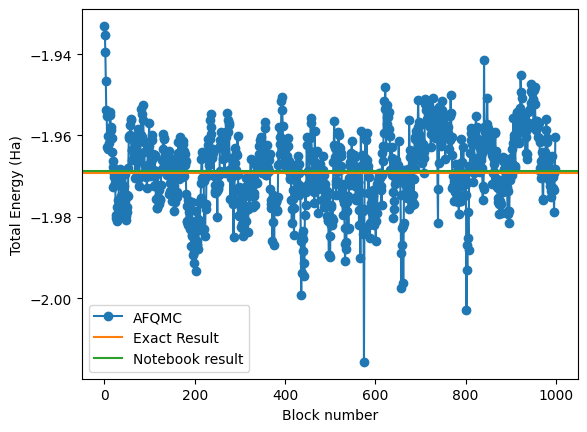

In [47]:
from ipie.analysis.extraction import extract_observable
import matplotlib.pyplot as plt
from ipie.analysis.blocking import reblock_minimal 

paper_result = -1.96922
analyzed_result = reblock_minimal(afqmc.estimators.filename, start_block=100)
notebook_energy = analyzed_result.ETotal_ac.values[0]
notebook_error = analyzed_result.ETotal_error_ac.values[0]

data = extract_observable(afqmc.estimators.filename)
plt.plot(data.ETotal, marker='o', label="AFQMC", color="C0")
plt.axhline(paper_result, label="Exact Result", color="C1")
plt.axhline(notebook_energy, label="Notebook result", color="C2")
plt.legend()
plt.xlabel("Block number")
plt.ylabel("Total Energy (Ha)")
print(f"paper result = {paper_result}")
print(f"notebook result = {notebook_energy} +/ {notebook_error}")